This notebook is a demo for ArchVelo. 

ArchVelo is a method for modeling gene regulation and inferring cell trajectories using scRNA+ATAC-seq. Here we apply ArchVelo to a E18 stage scRNA+ATAC mouse embryonic brain dataset. We apply ArchVelo, demonstrate its fits for several key markers and showcase archetypal velocity decomposition on the same UMAP.

Preprocessed matrices for this analysis should be downloaded into processed_data/ folder from  https://doi.org/10.6084/m9.figshare.30096616.v2

The inputs here are as follows:
1) adata_rna.h5ad - scRNA count matrix, preprocessed for ArchVelo analysis.
2) atac_AA.h5ad - scATAC count matrix, denoised via archetypal analysis and required to run ArchVelo
3) arches.h5ad - chromatin accessibility archetypes, obtained via archetypal analysis (AA) on the scATAC modality
4) gene_weights.csv - gene-specific loadings from AA on the scATAC modality
5) adata_atac.h5ad - scATAC count matrix, preprocessed for MultiVelo, only required for likelihood calculation to be consistent with MultiVelo. ptional

The original dataset is available through 10X (https://www.10xgenomics.com/datasets/fresh-embryonic-e-18-mouse-brain-5-k-1-standard-1-0-0) and the full analysis is available at https://github.com/pritykinlab/ArchVelo_notebooks


In [1]:
import ArchVelo as av

In [2]:
import numpy as np
import pandas as pd

import scanpy as sc
import os

In [3]:
import scvelo as scv
import multivelo as mv

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
num_comps = 10
n_jobs = 100

In [6]:
n_neigh = 50
n_pcs=30

In [7]:
data_outdir = 'processed_data/'
model_outdir = 'modeling_results/'
os.makedirs(model_outdir, exist_ok = True)

# Read in data

In [ ]:
# load processed RNA
adata_rna = sc.read_h5ad(data_outdir+'adata_rna.h5ad')
# Aggregated ATAC
adata_atac = sc.read_h5ad(data_outdir+'adata_atac.h5ad')
# Denoised ATAC
atac_AA = sc.read_h5ad(data_outdir+'adata_atac_AA_denoised.h5ad')
# Archetypes
smooth_arch = sc.read_h5ad(data_outdir+'arches.h5ad')
# Archetypal weights per gene
gene_weights = pd.read_csv(data_outdir+'gene_weights.csv', index_col = [0])
    

# Apply ArchVelo

In [ ]:
avel = av.apply_ArchVelo_full(adata_rna,
                    atac_AA,
                    adata_atac,
                    smooth_arch,
                    gene_weights,
                    model_outdir,
                    n_jobs = n_jobs,
                    n_neighbors = n_neigh,
                    n_pcs = n_pcs)

computing velocity graph (using 1/128 cores)


  0%|          | 0/3252 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'velo_s_norm_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:02) --> added 
    'latent_time', shared time (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velo_s_norm_umap', embedded velocity vectors (adata.obsm)


<Axes: title={'center': 'cell type abbr'}>

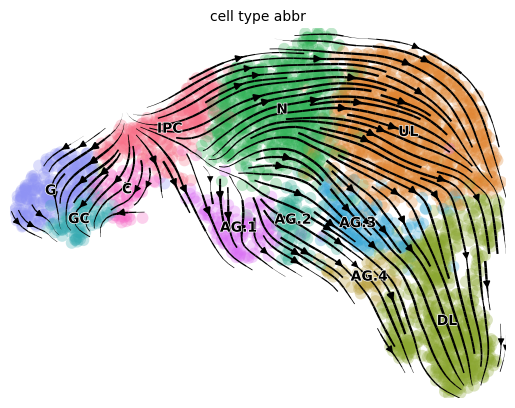

In [14]:
mv.velocity_graph(avel, vkey = 'velo_s')
mv.latent_time(avel)
mv.velocity_embedding_stream(avel, 
                             #vkey = 'velo_s',
                             show=False, 
                             color = 'cell_type_abbr', 
                             title = False)

In [36]:
avel.write(model_outdir+'archvelo_result.h5ad')

In [20]:
pal = dict(zip(avel.obs['cell_type_abbr'].cat.categories,avel.uns['cell_type_abbr_colors']))

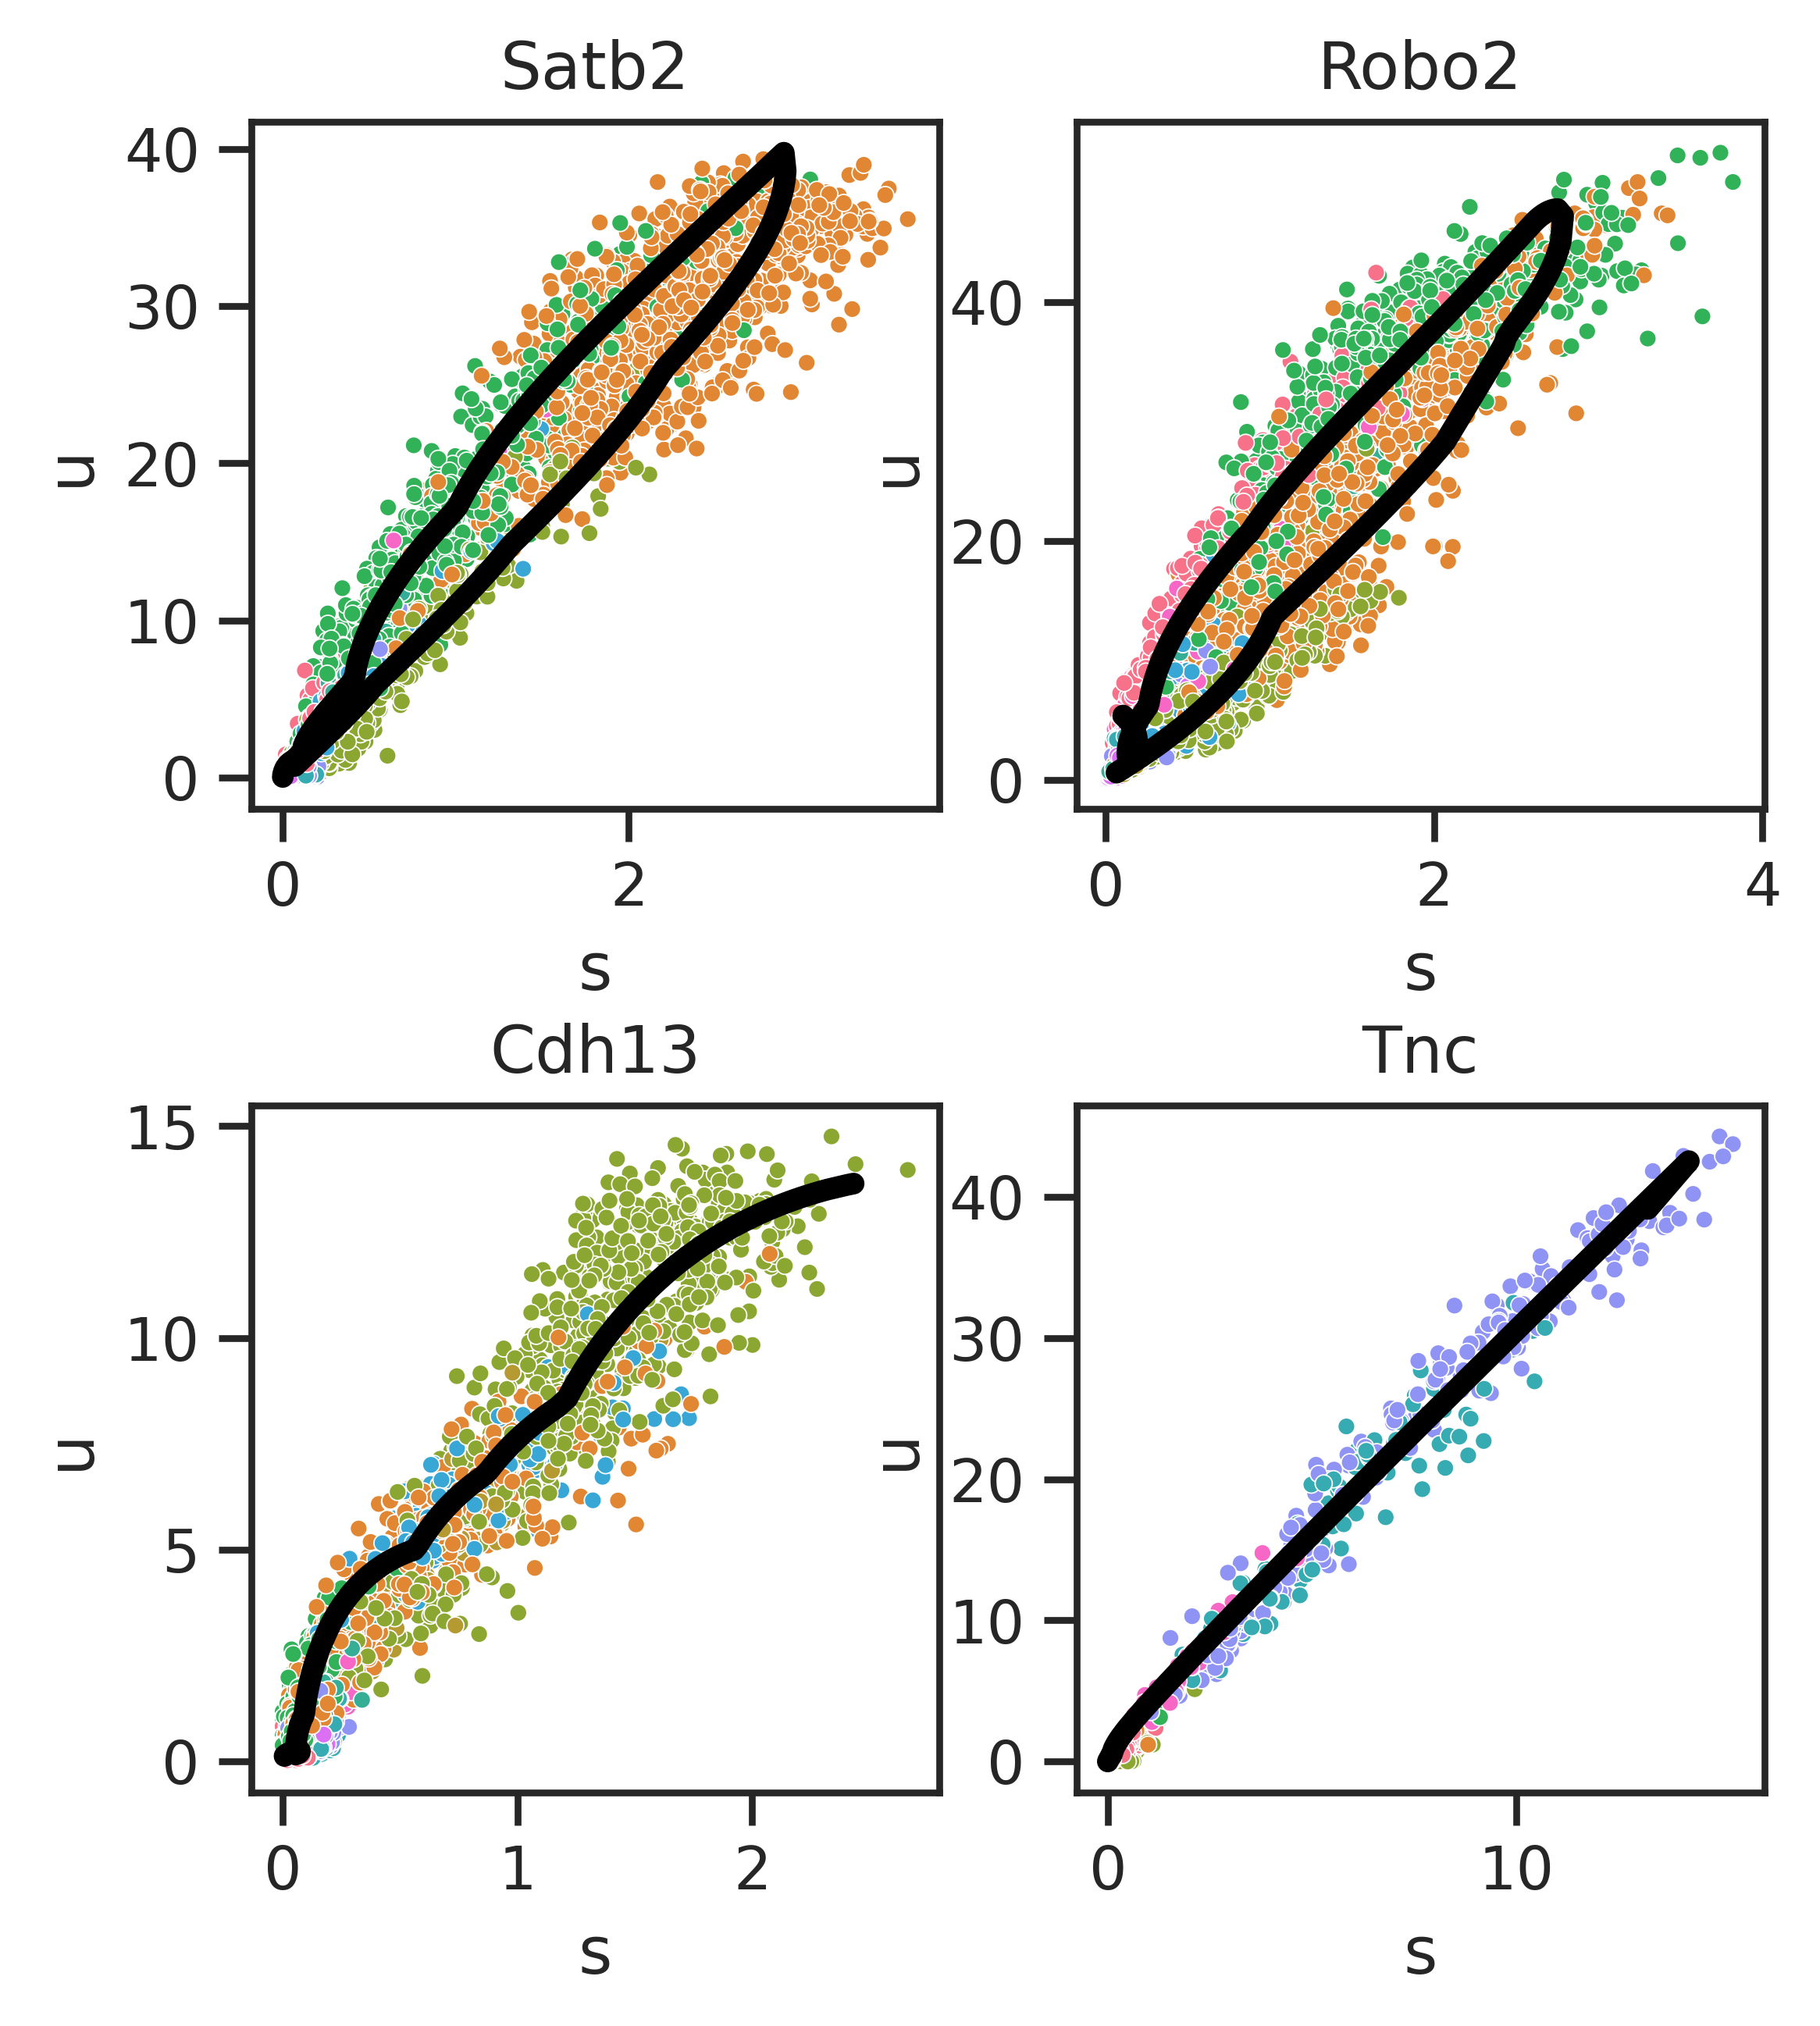

In [33]:
#some examples
sns.set(style = 'ticks', font_scale = 1)
genes = ['Satb2',  
         'Robo2',
         'Cdh13', 
         'Tnc']
fig, axes = plt.subplots(2,2,figsize = (5,6), 
                         dpi = 500)

i = 0
for g in genes:
    ax = axes[i //2, i %2]
    i+=1
    ax.set_box_aspect(1)
    av.plot_phase(avel, 
               g, 
               ax = ax,
               color_by = 'cell_type_abbr',
               pal = pal,
               s = 10,
                    )
    ax.set_title(g)
    ax.set_ylabel('u')
    ax.set_xlabel('s')

# Trajectory components

In [15]:
avel = sc.read_h5ad(model_outdir+'archvelo_result.h5ad')

computing velocity graph (using 1/128 cores)


  0%|          | 0/3252 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'velo_s_comp_1_norm_graph', sparse matrix with cosine correlations (adata.uns)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velo_s_comp_1_norm_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 1/128 cores)


  0%|          | 0/3252 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'velo_s_comp_3_norm_graph', sparse matrix with cosine correlations (adata.uns)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velo_s_comp_3_norm_umap', embedded velocity vectors (adata.obsm)


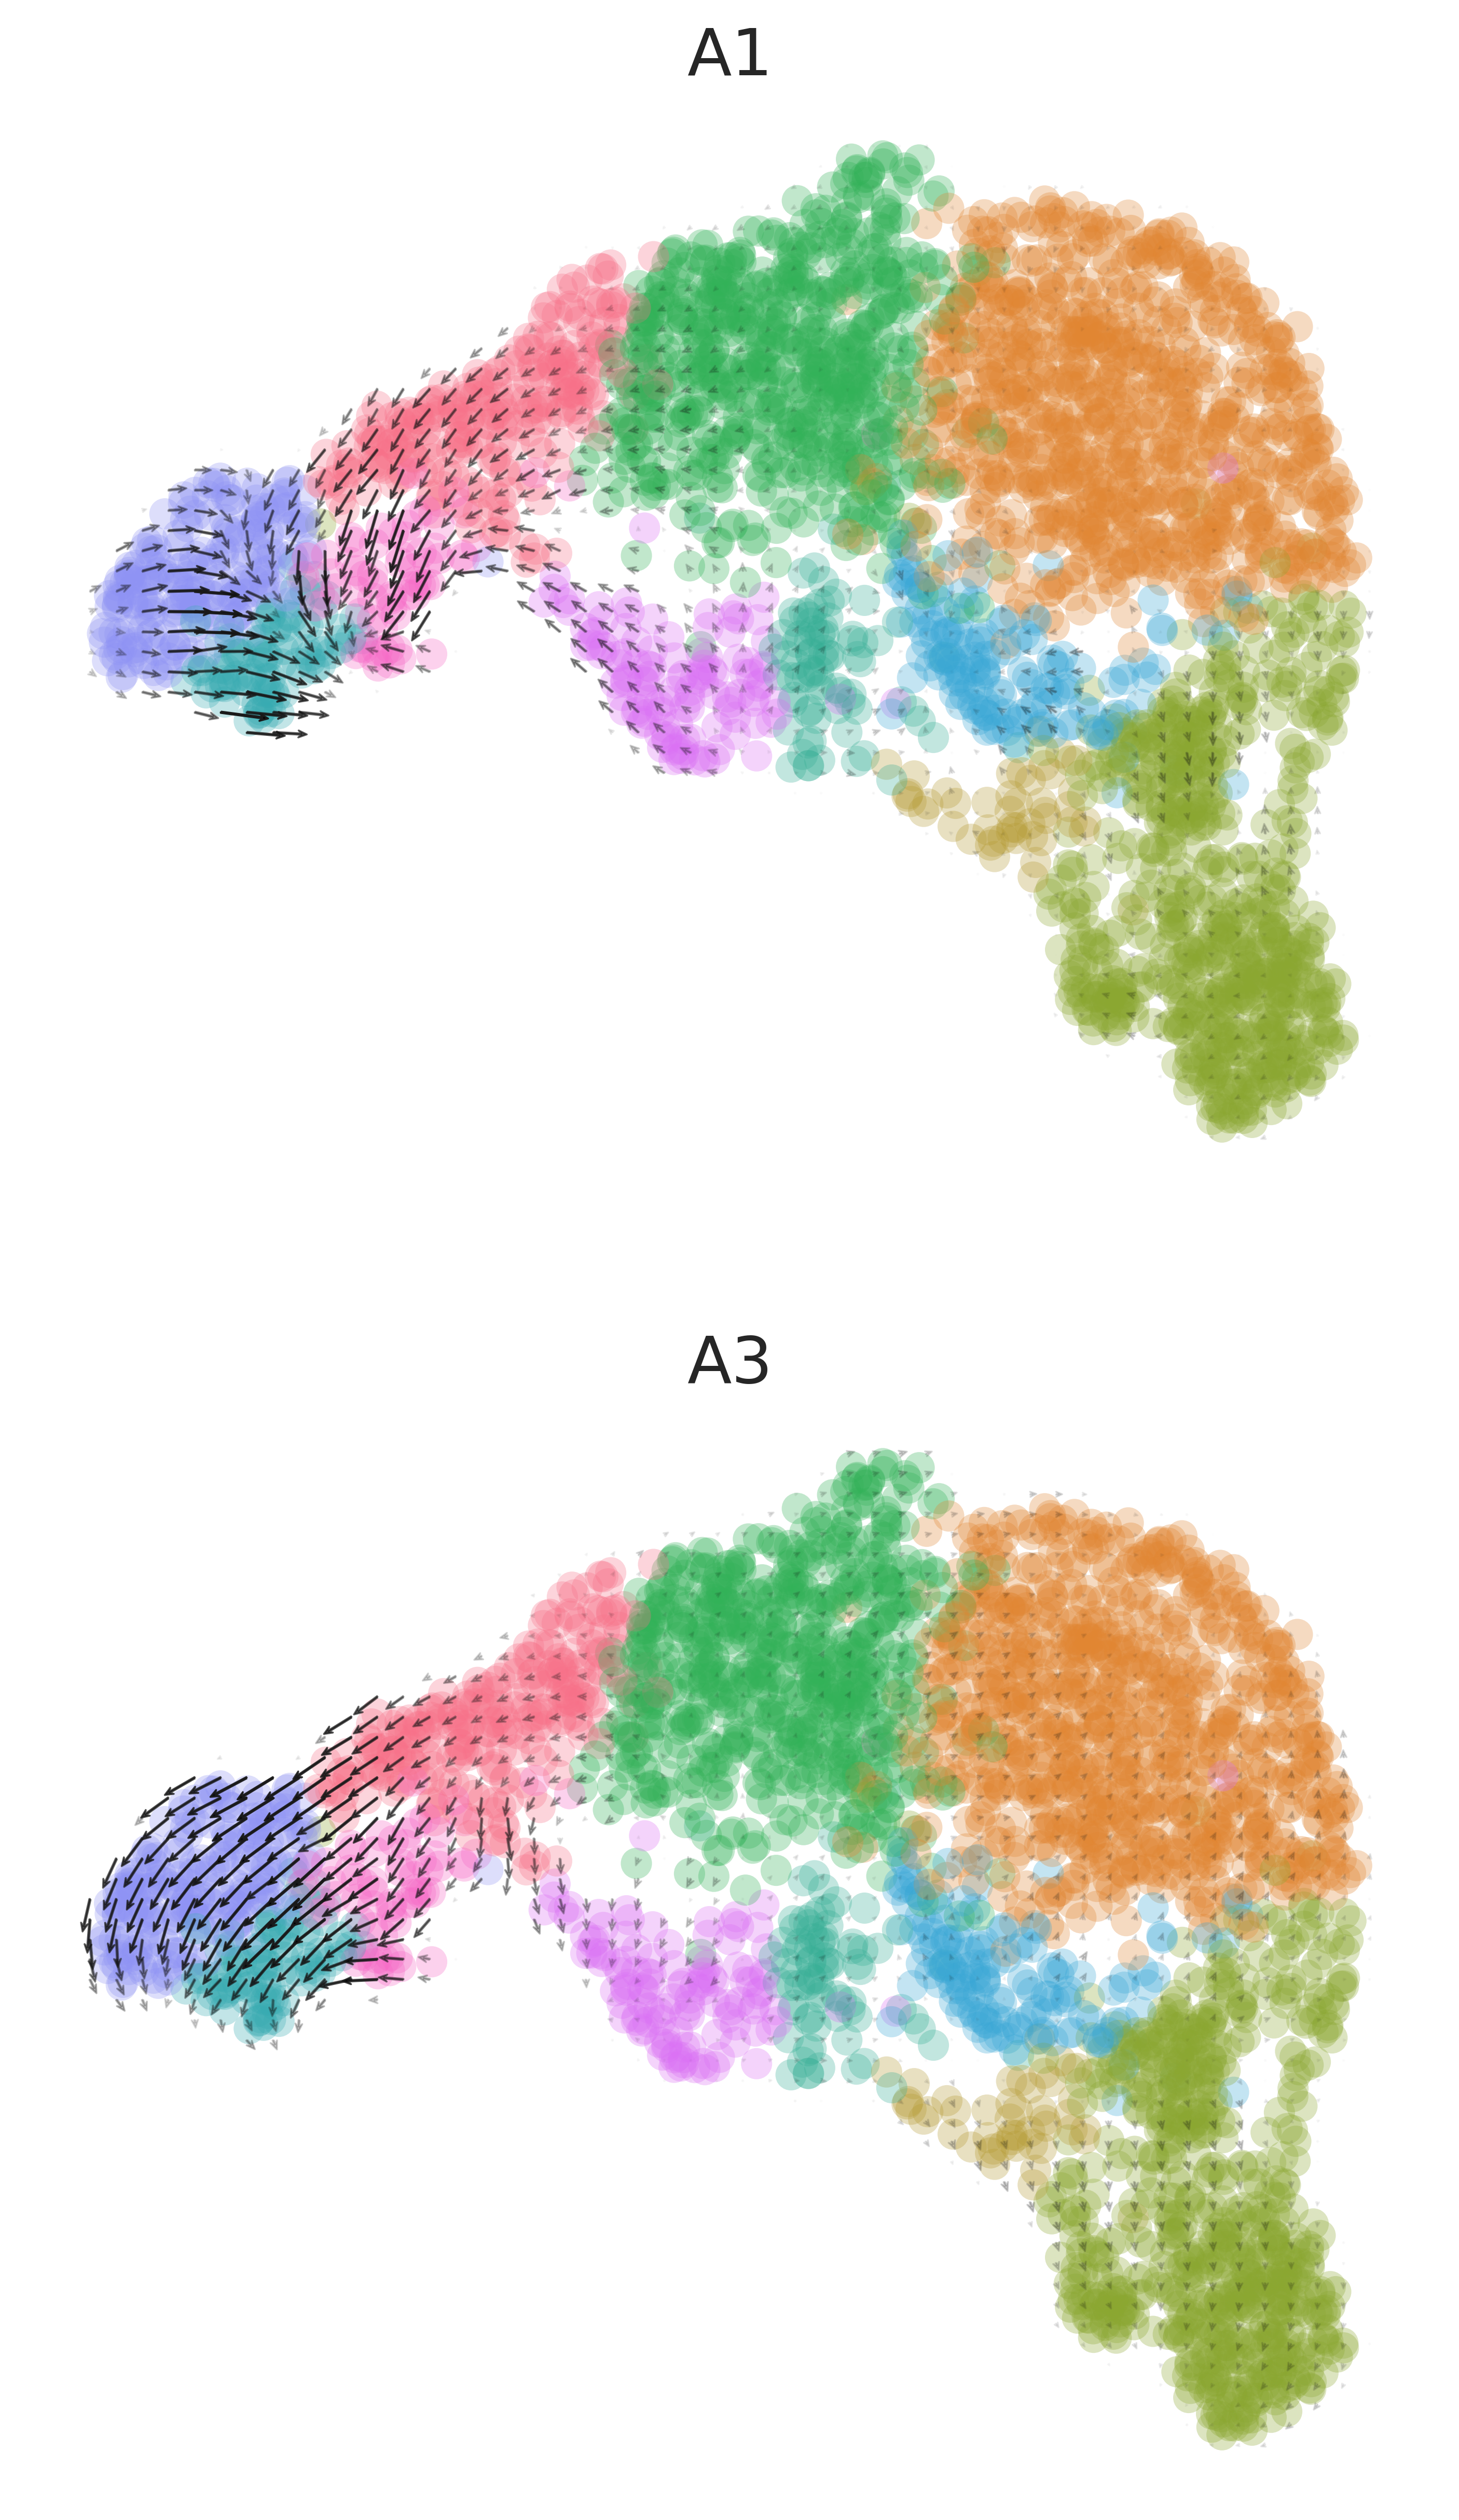

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [19]:
fig, axes = plt.subplots(2,1, dpi = 500, figsize = (7,12))
j = 0
for i in [1,3]:
    comp = i
    ax = axes[j]
    j+=1
    key_vel = 'velo_s_comp_'+str(comp)
    av.vis_velo_on_grid(avel,
                 key_vel = key_vel,
                 color_by = 'cell_type_abbr',
                 title = 'A'+str(i),
                 recalculate_graph = True,
                 ax = ax)